In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("Notebook ready")
print("Pandas:", pd.__version__)


Notebook ready
Pandas: 2.3.3


In [ ]:
import os
os.getcwd()


'c:\\Users\\tahai\\OneDrive\\Desktop\\Masterarbeit\\aiops-logs-anomaly\\notebooks'

In [ ]:
from pathlib import Path

PROJECT_ROOT = Path("..")
LOG_PATH = PROJECT_ROOT / "data" / "raw" / "sample_cicd.log"

with open(LOG_PATH, "r") as f:
    logs = f.readlines()

logs


['2024-01-10 12:30:01 INFO Build started\n',
 '2024-01-10 12:30:05 INFO Cloning repository\n',
 '2024-01-10 12:30:15 INFO Running tests\n',
 '2024-01-10 12:30:22 ERROR TestLogin failed\n',
 '2024-01-10 12:30:23 ERROR Build failed\n',
 '2024-01-10 12:31:10 INFO Build started\n',
 '2024-01-10 12:31:20 INFO Running tests\n',
 '2024-01-10 12:31:35 INFO Build successful\n']

In [ ]:
import re

LOG_PATTERN = re.compile(
    r"(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) "
    r"(?P<level>INFO|WARN|ERROR) "
    r"(?P<message>.*)"
)

def parse_log_line(line):
    match = LOG_PATTERN.match(line)
    if match:
        return match.groupdict()
    return None


In [ ]:
parsed_logs = []

for line in logs:
    parsed = parse_log_line(line)
    if parsed:
        parsed_logs.append(parsed)

parsed_logs


[{'timestamp': '2024-01-10 12:30:01',
  'level': 'INFO',
  'message': 'Build started'},
 {'timestamp': '2024-01-10 12:30:05',
  'level': 'INFO',
  'message': 'Cloning repository'},
 {'timestamp': '2024-01-10 12:30:15',
  'level': 'INFO',
  'message': 'Running tests'},
 {'timestamp': '2024-01-10 12:30:22',
  'level': 'ERROR',
  'message': 'TestLogin failed'},
 {'timestamp': '2024-01-10 12:30:23',
  'level': 'ERROR',
  'message': 'Build failed'},
 {'timestamp': '2024-01-10 12:31:10',
  'level': 'INFO',
  'message': 'Build started'},
 {'timestamp': '2024-01-10 12:31:20',
  'level': 'INFO',
  'message': 'Running tests'},
 {'timestamp': '2024-01-10 12:31:35',
  'level': 'INFO',
  'message': 'Build successful'}]

In [ ]:
df = pd.DataFrame(parsed_logs)
df


,timestamp,level,message
0,2024-01-10 12:30:01,INFO,Build started
1,2024-01-10 12:30:05,INFO,Cloning repository
2,2024-01-10 12:30:15,INFO,Running tests
3,2024-01-10 12:30:22,ERROR,TestLogin failed
4,2024-01-10 12:30:23,ERROR,Build failed
5,2024-01-10 12:31:10,INFO,Build started
6,2024-01-10 12:31:20,INFO,Running tests
7,2024-01-10 12:31:35,INFO,Build successful


In [ ]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.dtypes

df = df.set_index("timestamp")
df


,level,message
timestamp,,
2024-01-10 12:30:01,INFO,Build started
2024-01-10 12:30:05,INFO,Cloning repository
2024-01-10 12:30:15,INFO,Running tests
2024-01-10 12:30:22,ERROR,TestLogin failed
2024-01-10 12:30:23,ERROR,Build failed
2024-01-10 12:31:10,INFO,Build started
2024-01-10 12:31:20,INFO,Running tests
2024-01-10 12:31:35,INFO,Build successful


In [ ]:
features = df.resample("1min").agg(
    log_count=("level", "count"),
    error_count=("level", lambda x: (x == "ERROR").sum()),
    info_count=("level", lambda x: (x == "INFO").sum())
)

features = features.fillna(0)
features


,log_count,error_count,info_count
timestamp,,,
2024-01-10 12:30:00,5,2,3
2024-01-10 12:31:00,3,0,3


<Axes: title={'center': 'Log activity per minute'}, xlabel='timestamp'>

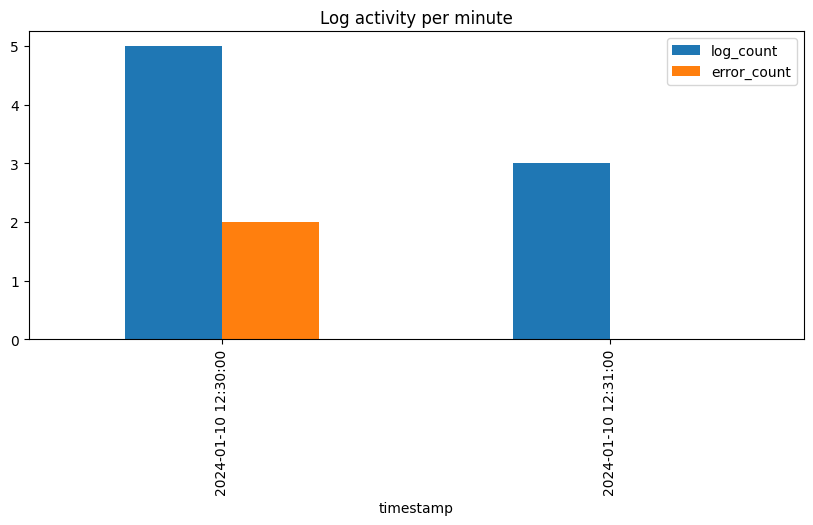

In [ ]:
features[["log_count", "error_count"]].plot(
    kind="bar",
    figsize=(10, 4),
    title="Log activity per minute"
)


In [ ]:
features["baseline_anomaly"] = features["error_count"] > 0
features

,log_count,error_count,info_count,baseline_anomaly
timestamp,,,,
2024-01-10 12:30:00,5,2,3,True
2024-01-10 12:31:00,3,0,3,False


In [ ]:
X = features[["log_count", "error_count", "info_count"]]
X

,log_count,error_count,info_count
timestamp,,,
2024-01-10 12:30:00,5,2,3
2024-01-10 12:31:00,3,0,3


In [ ]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(
    n_estimators=100,
    contamination=0.2,   # small dataset → higher contamination
    random_state=42
)

model.fit(X)


,"n_estimators n_estimators: int, default=100The number of base estimators in the ensemble.",100
,"max_samples max_samples: ""auto"", int or float, default=""auto""The number of samples to draw from X to train each base estimator.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` samples.- If ""auto"", then `max_samples=min(256, n_samples)`.If max_samples is larger than the number of samples provided,all samples will be used for all trees (no sampling).",'auto'
,"contamination contamination: 'auto' or float, default='auto'The amount of contamination of the data set, i.e. the proportionof outliers in the data set. Used when fitting to define the thresholdon the scores of the samples.- If 'auto', the threshold is determined as in the original paper.- If float, the contamination should be in the range (0, 0.5]... versionchanged:: 0.22 The default value of ``contamination`` changed from 0.1 to ``'auto'``.",0.2
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator.- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.Note: using a float number less than 1.0 or integer less than number offeatures will enable feature subsampling and leads to a longer runtime.",1.0
,"bootstrap bootstrap: bool, default=FalseIf True, individual trees are fit on random subsets of the trainingdata sampled with replacement. If False, sampling without replacementis performed.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for :meth:`fit`. ``None`` means 1unless in a :obj:`joblib.parallel_backend` context. ``-1`` means usingall processors. See :term:`Glossary ` for more details.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo-randomness of the selection of the featureand split values for each branching step and each tree in the forest.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity of the tree building process.",0
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fit a wholenew forest. See :term:`the Glossary `... versionadded:: 0.21",False


In [ ]:
features["iforest_anomaly"] = model.predict(X) == -1
features


,log_count,error_count,info_count,baseline_anomaly,iforest_anomaly
timestamp,,,,,
2024-01-10 12:30:00,5,2,3,True,False
2024-01-10 12:31:00,3,0,3,False,False


In [ ]:
comparison = features[["baseline_anomaly", "iforest_anomaly"]]
comparison


,baseline_anomaly,iforest_anomaly
timestamp,,
2024-01-10 12:30:00,True,False
2024-01-10 12:31:00,False,False


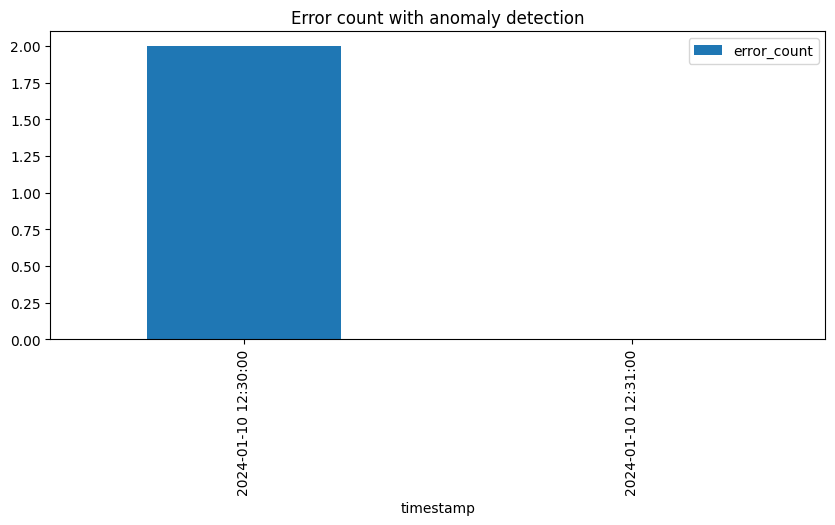

In [ ]:
features[["error_count"]].plot(
    kind="bar",
    figsize=(10, 4),
    title="Error count with anomaly detection"
)
for idx, is_anomaly in features["iforest_anomaly"].items():
    if is_anomaly:
        plt.axvline(idx, color="red", linestyle="--", alpha=0.5)
